In [ ]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')
validation = pd.read_csv('./data/validation_sample.csv')

In [ ]:
train

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...
...,...,...,...
472967,472967,0,Feb 28 10:10:06 localhost logstash: 7738 error:
472968,472968,1,type=SYSCALL msg=audit(1611890993.458:321827):...
472969,472969,0,"Oct 12 02:20:29 localhost kibana: {""type"":""log..."
472970,472970,0,"Jan 15 09:02:43 localhost kibana: {""type"":""err..."


In [ ]:
train.corr()

,id,level
id,1.000000,0.000909
level,0.000909,1.000000


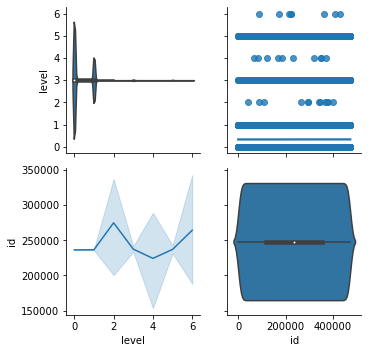

In [ ]:
grid = sns.PairGrid(train[['full_log','level','id']]) # 상관관계

grid.map_upper(sns.regplot)
grid.map_lower(sns.lineplot)
grid.map_diag(sns.violinplot)

plt.show()

In [ ]:
# 열과 행 생략없이 보기 위한 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [ ]:
train.head()

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...


In [ ]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472972 entries, 0 to 472971
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        472972 non-null  int64 
 1   level     472972 non-null  int64 
 2   full_log  472972 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.8+ MB


In [ ]:
train['full_log'].describe()

count                                       472972
unique                                      404136
top       error: cannot open Packages database in 
freq                                           138
Name: full_log, dtype: object

In [ ]:
train['level'].describe()

count    472972.000000
mean          0.330140
std           0.606897
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           6.000000
Name: level, dtype: float64

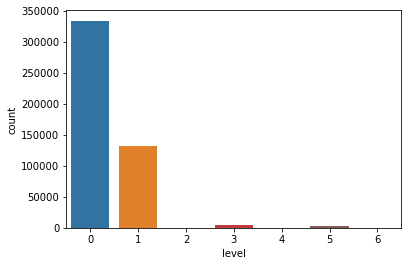

In [ ]:
sns.countplot(x = train['level'])
plt.show()

In [ ]:
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418916 entries, 0 to 1418915
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   id        1418916 non-null  int64 
 1   full_log  1418916 non-null  object
dtypes: int64(1), object(1)
memory usage: 21.7+ MB


In [ ]:
test['full_log'].describe()

count                                               1418916
unique                                              1095951
top       error: db5 error(-30973) from dbenv->failchk: ...
freq                                                    432
Name: full_log, dtype: object

In [ ]:
test['full_log'].str.extract('^([^ ]+)(?: |$)')

,0
0,Feb
1,Sep
2,type=SYSCALL
3,Jan
4,type=SYSCALL
...,...
1418911,Jan
1418912,Jan
1418913,type=SYSCALL
1418914,Jan


In [ ]:
test['first_word'] = test['full_log'].str.extract('^([^ ]+)(?: |$)')

In [ ]:
test['first_word'].nunique()

28

In [ ]:
test['first_word'].value_counts().index

Index(['Jan', 'type=SYSCALL', 'Feb', 'Dec', 'Oct', 'Sep', 'Nov', 'Mar',
       'level', 'ossec:', 'File', 'System', 'error:', 'oscap:', 'type=AVC',
       'E:', 'type=ANOM_ABEND', '2021', 'NTFS', 'Trojaned', 'Windows', 'The',
       'type=ANOM_PROMISCUOUS', '2020', 'OpenSCAP', '--MARK--:', 'juniper',
       'type=USER_AVC'],
      dtype='object')

In [ ]:
pivot = test.pivot_table(values='full_log', index='first_word', aggfunc='count', fill_value=0)
pivot = pivot.loc[test['first_word'].value_counts().index]
pivot
# 첫 단어 종류가 train에비해 2개 더 생김
# type=ANOM_ABEND 
# type=ANOM_PROMISCUOUS 

,full_log
Jan,622574
type=SYSCALL,349290
Feb,105762
Dec,77253
Oct,71817
Sep,69486
Nov,65784
Mar,36211
level,7180
ossec:,3850


In [ ]:
baseline_submission = pd.read_csv('baseline_submission.csv')
baseline_submission

,id,level
0,1000000,0
1,1000001,0
2,1000002,1
3,1000003,0
4,1000004,1
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,1
1418914,2418914,0


In [ ]:
baseline_submission.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418916 entries, 0 to 1418915
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   id      1418916 non-null  int64
 1   level   1418916 non-null  int64
dtypes: int64(2)
memory usage: 21.7 MB


In [ ]:
baseline_submission['level'].value_counts().sort_index()
# 2, 4, 6 이 굉장히 적음
# 0, 1에 data가 편중되어있음
# 3, 5, 7에 해당하는 data가 꽤 있을것으로 예상

0    998113
1    395080
2        34
3     12778
4        13
5      6259
6        10
7      6629
Name: level, dtype: int64

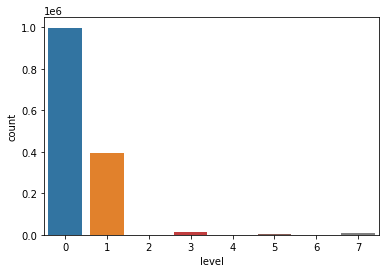

In [ ]:
sns.countplot(x = baseline_submission['level'])
plt.show()

In [ ]:
# 한글이 포함된 경우 level은 항상 0임을 확인했습니다. => 한글 = 0레벨
# error 메세지가 한글로 사용되는 경우가 많음 -> 한글 <kor>로 마스킹